In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns
import time

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [81]:
s0 = pd.read_csv("./data/sale_to_customer_rl_15_price_change_data.csv", usecols = ['d_index_1', 'd_index_2', 'name',
		'cusip', 'state', 'coupon', 'maturity', 'yield', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'price', 'dprice', 'holdtime'])
#d = extract.get_data("./data/TMC_020617.csv")
#d = extract.clean_data(d)

In [82]:
s0.head()

,dprice,holdtime,d_index_1,d_index_2,cusip,price,yield,tradedate,name,state,coupon,maturity,issuetype,issuesource,rtg
0,0.476,1.0,0,2676,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
1,0.488,2.0,0,2677,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
2,3.239,8.0,0,8287,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
3,3.089,9.0,0,9511,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
4,3.476,9.0,0,9512,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6


In [83]:
#print s0[(s0.cusip == '45471AKG6')&(s0.tradedate == 2.0)]

In [84]:
d_index_1 = s0.pop('d_index_1')
d_index_2 = s0.pop('d_index_2')

In [85]:
s_name_features = extract.build_name_features(s0, num_general_words = 50, num_long_words = 250, long_word_length = 5)
s_state_features = extract.build_state_features(s0, num_states = None)
s_other_features = extract.build_other_text_features(s0, tradetype=False)
s = pd.concat([s0.drop(['state', 'name', 'issuetype', 'issuesource', 'cusip', 'price'], axis = 1), s_state_features, s_other_features, s_name_features], axis = 1)
s = s.dropna()
s = s[s.holdtime < 7] #pick out only data with holdtime < max days

In [86]:
s.head()

,dprice,holdtime,yield,tradedate,coupon,maturity,rtg,Alabama,Alaska,Arizona,...,290,291,292,293,294,295,296,297,298,299
0,0.476,1.0,4.037,2.0,4.0,6692.0,6,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.488,2.0,4.037,2.0,4.0,6692.0,6,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11,0.573,1.0,4.045,2.0,4.0,6692.0,6,0,0,0,...,0,1,0,0,0,0,0,0,0,0
12,0.585,2.0,4.045,2.0,4.0,6692.0,6,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22,0.012,1.0,4.000,3.0,4.0,6691.0,6,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Try a Random Forest Regressor

In [87]:
dprice = s.pop('dprice')

In [88]:
#s_train, s_test, dp_train, dp_test = train_test_split(s, dprice, test_size=0.20, random_state=180)
s_train = s[s.tradedate < 25].values
dp_train = dprice[s.tradedate < 25].values
s_test = s[s.tradedate >= 25].values
dp_test = dprice[s.tradedate >= 25].values

In [89]:
#s_test[dp_test < -10]
#(dp_test < -10).size
#d_index.size
#dp_test[dp_test < -10]

### Want to optimize the max_depth and n_estimators parameters of the regressor with respect to the percentage of winning predictions that are actually winners. To do this, we construct a custom scorer function

In [287]:
def scorer(clf, X_test, y_test):
    #we want to maximize f1 score value = 2*(precision*recall)/(precision + recall)
    y_predict = clf.predict(X_test)
    recall = float(np.sum(y_predict[y_test > 0] > 0))/np.sum(y_test > 0) #percent of true dprice>0 cases model can predict
    precision = float(np.sum(y_test[y_predict > 0] > 0))/np.sum(y_predict > 0) #percent of increases predicted are actually correct
    return 2*precision*recall/(precision + recall)

In [90]:
#parameters = {'max_depth':[10, 15, 20, 25], 'n_estimators':[50, 100], 'criterion':['mse']}
#rfr = RandomForestRegressor()
#clf = GridSearchCV(rfr, param_grid = parameters, scoring = scorer)
clf = RandomForestRegressor(max_depth = None, n_estimators = 100, max_features = None)

In [91]:
t0 = time.time()
clf.fit(s_train, dp_train)
print time.time() - t0

161.021565914


In [92]:
#clf.cv_results_
#estimator = clf.best_estimator_
#clf.best_params_

In [93]:
#dp_predict = estimator.predict(s_test)
dp_predict = clf.predict(s_test)

In [94]:
dp_predict[100:200]

array([-0.23817321, -0.23817321, -0.23817321, -0.23817321, -0.23817321,
       -0.23817321, -0.23817321,  0.47331444,  0.47331444,  0.37428   ,
        0.37428   ,  0.37428   ,  0.37428   , -0.05398395, -0.05398395,
       -0.05398395, -0.05398395, -0.23817321, -0.23817321, -0.23817321,
       -0.23817321, -0.23817321, -0.23817321, -0.23817321,  0.47331444,
        0.47331444,  0.37428   ,  0.37428   ,  0.37428   ,  0.37428   ,
       -0.05398395, -0.05398395, -0.05398395, -0.05398395, -0.23817321,
       -0.23817321, -0.23817321, -0.23817321, -0.23817321, -0.23817321,
       -0.23817321,  0.47331444,  0.47331444,  0.37428   ,  0.37428   ,
        0.37428   ,  0.37428   , -0.05398395, -0.05398395, -0.05398395,
       -0.05398395, -0.23817321, -0.23817321, -0.23817321, -0.23817321,
       -0.23817321, -0.23817321, -0.23817321,  0.47331444,  0.47331444,
        0.37428   ,  0.37428   ,  0.37428   ,  0.37428   , -0.05398395,
       -0.05398395, -0.05398395, -0.05398395, -0.23817321, -0.23

In [95]:
dp_test[100:200]

array([ 0.843,  0.54 ,  0.555, -1.375,  0.   ,  0.   , -0.375, -1.875,
       -1.375,  0.   ,  0.   ,  0.   , -2.919, -0.375, -0.375, -0.375,
       -1.675,  0.843,  0.54 ,  0.555, -1.375,  0.   ,  0.   , -0.375,
       -1.875, -1.375,  0.   ,  0.   ,  0.   , -2.919, -0.375, -0.375,
       -0.375, -1.675,  0.843,  0.54 ,  0.555, -1.375,  0.   ,  0.   ,
       -0.375, -1.875, -1.375,  0.   ,  0.   ,  0.   , -2.919, -0.375,
       -0.375, -0.375, -1.675,  0.843,  0.54 ,  0.555, -1.375,  0.   ,
        0.   , -0.375, -1.875, -1.375,  0.   ,  0.   ,  0.   , -2.919,
       -0.375, -0.375, -0.375, -1.675,  0.843,  0.54 ,  0.555, -1.375,
        0.   ,  0.   , -0.375, -1.875, -1.375,  0.   ,  0.   ,  0.   ,
       -2.919, -0.375, -0.375, -0.375, -1.675,  0.843,  0.54 ,  0.555,
       -1.375,  0.   ,  0.   , -0.375, -1.875, -1.375,  0.   ,  0.   ,
        0.   , -2.919, -0.375, -0.375])

In [96]:
I1 = dp_test > 0
np.sum(I1)
#scorer(estimator, s_test, dp_test)

4849

### below: of the actual test cases where price increased, which fraction were predicted by the model to be an increase?

In [97]:
float(np.sum(dp_predict[I1] > 0))/np.sum(I1)

0.6197154052381935

In [98]:
I2 = (dp_test > 0) & (dp_predict > 0)
np.sum(I2)

3005

### below: percentage of samples that were predicted by model to be increase and were actually an increase.

In [99]:
precision_ratio = float(np.sum(I2))/np.sum(dp_predict > 0)
precision_ratio

0.651561144839549

### below: percentage of total predictions correct

In [100]:
float(np.sum((dp_predict>0) == (dp_test>0)))/dp_test.size

0.6310274778146049

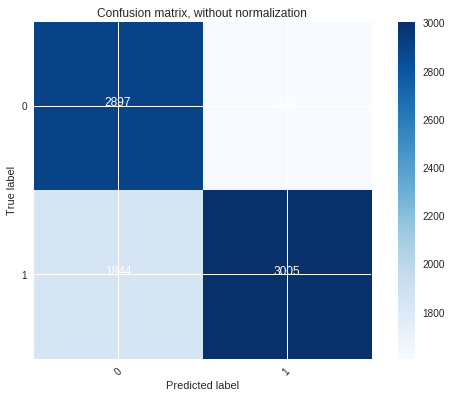

In [101]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

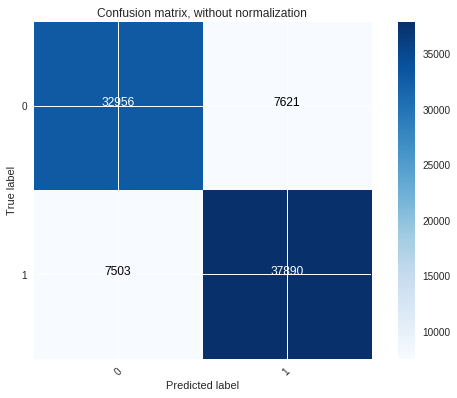

In [102]:
cnf_matrix = confusion_matrix((dp_train>0).astype(np.int), (clf.predict(s_train)>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

### For correctly predicted winners, what are typical values of dprice? Also plot distribution of dprice_test when winner is predicted but it's actually a loser on same axes.

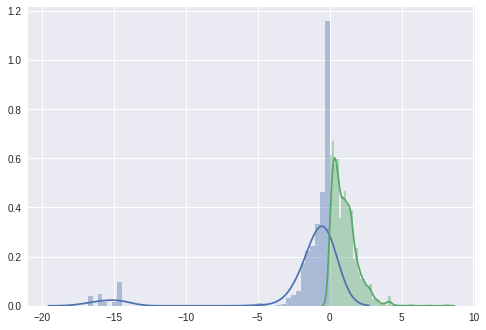

In [103]:
I2 = (dp_test > 0) & (dp_predict > 0)
dp_slice_winner = dp_test[I2]
dp_slice_loser = dp_test[(dp_test < 0) & (dp_predict > 0)]
#print dp_slice_loser.min(), dp_slice_loser.max(), dp_slice_loser.mean()
sns.distplot(dp_slice_loser)
sns.distplot(dp_slice_winner)
plt.show()

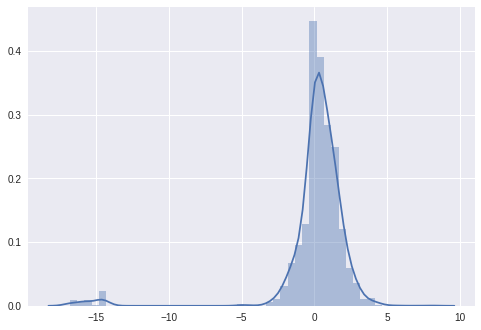

0.112516695577 2.652776254


In [104]:
dp_predict_winner_density = dp_test[dp_predict > 0]
sns.distplot(dp_predict_winner_density)
plt.show()
print dp_predict_winner_density.mean(), dp_predict_winner_density.std()

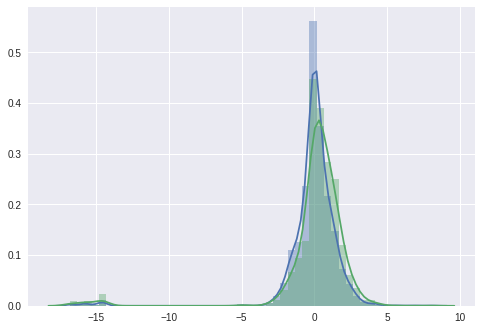

-0.0358788623971 1.994015107


In [105]:
sns.distplot(dp_test)
sns.distplot(dp_predict_winner_density)
plt.show()
print dp_test.mean(), dp_test.std()

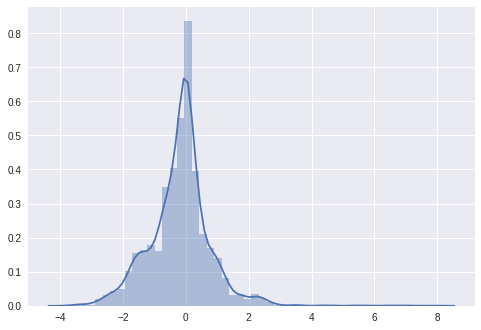

-0.180236658933 0.977753012516


In [107]:
#distribution of dprice when dp_predict < 0
dp_predict_loser_density = dp_test[dp_predict < 0]
sns.distplot(dp_predict_loser_density)
plt.show()
print dp_predict_loser_density.mean(), dp_predict_loser_density.std()

In [110]:
print dp_test.mean(), dp_test.std()
print dp_train.mean(), dp_train.std()

-0.0358788623971 1.994015107
0.130199383506 1.11328779623


### Expected gains

In [111]:
I3 = dp_predict > 0
E = np.sum(dp_test[I3])/np.sum(I3)
print E

0.112516695577


In [112]:
#clf.best_estimator_.feature_importances_[:20]
clf.feature_importances_[:20]

array([  9.02189076e-02,   3.28728732e-01,   1.64749453e-01,
         3.91357111e-02,   9.64559512e-02,   2.53610017e-02,
         5.54793444e-04,   8.61337326e-06,   4.16986973e-04,
         3.58964807e-06,   4.21299547e-03,   1.57592997e-04,
         1.81413999e-03,   1.07364068e-04,   1.10803121e-04,
         2.59170074e-03,   4.00669458e-04,   2.40161219e-05,
         5.43424460e-05,   5.49470782e-06])

In [114]:
#important_features_indices = np.where(clf.best_estimator_.feature_importances_ > 0.01)
#ordered_indices = sorted(range(s.shape[1]), key=clf.best_estimator_.feature_importances_.__getitem__)
important_features_indices = np.where(clf.feature_importances_ > 0.001)
ordered_indices = sorted(range(s.shape[1]), key=clf.feature_importances_.__getitem__)
ordered_indices.reverse()
ordered_indices[:20]

[1,
 2,
 4,
 0,
 3,
 5,
 397,
 110,
 236,
 66,
 36,
 395,
 399,
 374,
 10,
 377,
 378,
 379,
 65,
 74]

In [115]:
list(s.columns[ordered_indices[:30]])

['yield',
 'tradedate',
 'maturity',
 'holdtime',
 'coupon',
 'rtg',
 289,
 2,
 128,
 'ISSUE SOURCE: APPROPRIATIONS',
 'New Jersey',
 287,
 291,
 266,
 'California',
 269,
 270,
 271,
 'ISSUE SOURCE: AD VALOREM PROPERTY TAX',
 'ISSUE SOURCE: GENERAL FUND',
 296,
 'ISSUE SOURCE: GOVT. FD./GRANT REV.',
 'ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.',
 277,
 'ISSUE TYPE: REVENUE BONDS',
 'Florida',
 251,
 42,
 'ISSUE TYPE: GENERAL OBLIGATION UNLTD',
 29]

In [116]:
#clf.best_estimator_.feature_importances_[ordered_indices[:20]]
clf.feature_importances_[ordered_indices[:20]]

array([ 0.32872873,  0.16474945,  0.09645595,  0.09021891,  0.03913571,
        0.025361  ,  0.02041451,  0.01914593,  0.01654903,  0.01111606,
        0.01074621,  0.00686973,  0.00551762,  0.00462256,  0.004213  ,
        0.00399589,  0.00371888,  0.00337633,  0.00336001,  0.00335913])